This is a notebook for extracting the locomotor parameters (as well as how they change over time, etc. which serve as inputs to out RW simulations).

## Load packages and functions

In [3]:
import pandas as pd
import numpy as np
import io, yaml
from tqdm.notebook import tqdm
import skimage.measure
import math
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

from scipy import stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from fitter import Fitter, get_common_distributions, get_distributions

%run -i helper_functions.py
%run -i plottingfunctions_singlespot.py
%run -i CreateNewDataFrames_singlespot_v2.py

In [2]:
# %run -i helper_functions.py
# import inspect
# inspect.getfullargspec(fitGMM)
# inspect.getfullargspec(GetParamGuessAndBounds)

In [52]:
# folder to save figures
foldername_save = './DataAnalysis/'
# foldername_save = './CorfasDataAnalysis/'

In [4]:
# colors for plotting
condcolors = {'0-125M_24hr': 'orangered', '0-125M_40hr': 'brown','0M_24hr': 'lightseagreen','0M_40hr':'teal'}
# condcolors = {'Gr43a-40hr': 'magenta', 'Gr5a-40hr': 'pink'}


In [5]:
# condcolors['0-125M_24hr']

'orangered'

# Loading the data
df is the variable that holds the per-frame data as a Pandas DataFrame object.

In [5]:
foldername = '~/Dropbox (HHMI)/LocalSearchData/data'
# CorfasGr5a_fns = [foldername + '/Corfas_Gr5a_single_unknown_opto_perframe_Gr5a-40hr.feather']
# CorfasGr43a_fns = [foldername + '/Corfas_Gr43a_single_unknown_opto_perframe_Gr43a-40hr.feather']
WTnosu_fns = [foldername + '/JR_CantonSMH_single_dark_5ul_perframe_0M_{}hr.feather'.format(t) for t in ['24', '40']]
WTsucrose_fns = [foldername + '/JR_CantonSMH_single_dark_5ul_perframe_0-125M_{}hr.feather'.format(t) for t in ['24', '40']]
# Ornosu_fn = [foldername + '/JR_Or83b_single_dark_5ul_perframe_0M_24hr.feather']
# Orsucrose_fn = [foldername + '/JR_Or83b_single_dark_5ul_perframe_0-125M_{}hr.feather'.format(t) for t in ['24', '40']]
# EPGkir_fns = [foldername + '/JR_SS96xCS-Kir_single_dark_5ul_perframe_0-125M_{}hr.feather'.format(t) for t in ['24', '40']]
# EPGTNT_fns = [foldername + '/JR_SS96xCSMH-TNT_single_dark_5ul_perframe_0-125M_{}hr.feather'.format(t) for t in ['24', '40']]
# Tmem_fns = [foldername + '/JR_Tmem63_single_dark_5ul_perframe_0-125M_24hr.feather'] # humidity mutants

# Optofiles = CorfasGr43a_fns + CorfasGr5a_fns
# Gr43aOptofiles = CorfasGr43a_fns 
# Gr43aOpto_df = pd.concat([pd.read_feather(file) for file in Gr43aOptofiles], ignore_index=True)
# Gr5aOptofiles = CorfasGr5a_fns 
# Gr5aOpto_df = pd.concat([pd.read_feather(file) for file in Gr5aOptofiles], ignore_index=True)
WTfiles = WTnosu_fns + WTsucrose_fns 
WT_df = pd.concat([pd.read_feather(file) for file in WTfiles], ignore_index=True)
# Orfiles = Ornosu_fn + Orsucrose_fn 
# Or_df = pd.concat([pd.read_feather(file) for file in Orfiles], ignore_index=True)
# EPGkir_df = pd.concat([pd.read_feather(file) for file in EPGkir_fns], ignore_index=True)
# EPGTNT_df = pd.concat([pd.read_feather(file) for file in EPGTNT_fns], ignore_index=True)
# Tmem_df = pd.concat([pd.read_feather(file) for file in Tmem_fns], ignore_index=True)

# files = WTnosu_fns + WTsucrose_fns + Ornosu_fn + Orsucrose_fn + EPGkir_fns + EPGTNT_fns
# df = pd.concat([pd.read_feather(file) for file in files], ignore_index=True)

In [9]:
# combine dataframes for all genotypes into a list
# dfs_allgenotypes = [Gr43aOpto_df,Gr5aOpto_df]
dfs_allgenotypes = [WT_df]
# dfs_allgenotypes = [WT_df, Or_df, EPGkir_df, EPGTNT_df, Tmem_df]
numgenotypes = len(dfs_allgenotypes)
genotypeNames = ['WT'] 
# genotypeNames = ['Gr43a','Gr5a'] 
# genotypeNames = ['WT','Or','EPGkir','EPGTNT','Tmem']


In [7]:
# print(Gr43aOpto_df.columns)
# print(Gr5aOpto_df.columns)
# print(Or_df.columns)
# print(EPGkir_df.columns)
# print(EPGTNT_df.columns)


Description of individual columns of raw dataframe:
- *frame*: frame number of corresponding video
- *fly*: identifier of individual flies
- *condition*: condition label of respective fly (here: dietary condition)
- *genotype*: genotype of fly
- *dt*: elapsed time between frames
- *body_x*: x position of the fly's body/centroid (mm)
- *body_y*: y position of the fly's body/centroid (mm)
- *head_x*: x position of the fly's head (mm)
- *head_y*: y position of the fly's head (mm)
- *major*: length of the fly's major axis (mm)
- *minor*: length of the fly's minor axis (mm)
- *angle*: heading angle determine by line from body to head (rad, *$\in[-\pi,\pi)$*)
- *body_speed*: smoothed translational speed of body position
- *head_speed*: smoothed translational speed of head position
- *angular_speed*: speed of heading angle
- *distance_center*: distance to the center of the arena (mm)
- *distance_patch_0*: distance to the food patch 0 (mm)
- *ethogram*: ethogram/behavioral classification for frame
- *segment*: segment classification for frame

In [9]:
# print(WT_df.ethogram.unique())
# print(Or_df.ethogram.unique())
# print(EPGkir_df.ethogram.unique())
# print(EPGTNT_df.ethogram.unique())

ethogram states:
- 0 = at the border (to avoid border-related behaviors, e.g. scalloping)
- 1 = turn (high angular speed)
- 2 = run ()
- 3 = feeding (distance to food; low head speed)
- 4 = other behavior (jumps, grooming, etc.)

In [10]:
# WT_df.segment.unique()

segment states:
- 0 = at the border (same as for the ethogram)
- 1 = food spot visit
- 2 = local search loop (food -> food)
- 3 = finding the spot (border -> food)
- 4 = leaving the spot (food -> border)
- 5 = missing the spot (border -> border)

In [10]:
condnames_allgenotypes = []
numconds_allgenotypes = []
for genotypeIndx in range(numgenotypes):
    genotype = genotypeNames[genotypeIndx]
    print(genotype + ':')
    condnames_currgenotype, numconds_currgenotype = GetConds(dfs_allgenotypes[genotypeIndx])
    print(condnames_currgenotype, numconds_currgenotype)
    condnames_allgenotypes.append(condnames_currgenotype)
    numconds_allgenotypes.append(numconds_currgenotype)


WT:
['0M_24hr' '0M_40hr' '0-125M_24hr' '0-125M_40hr'] 4


In [11]:
numfliesVec_allgenotypes = []
totnumflies_allgenotypes = []
for genotypeIndx in range(numgenotypes):
    genotype = genotypeNames[genotypeIndx]
    print(genotype + ':')
    numfliesVec_currgenotype, totnumflies_currgenotype = GetNumFlies(dfs_allgenotypes[genotypeIndx])
    print(numfliesVec_currgenotype, totnumflies_currgenotype)
    numfliesVec_allgenotypes.append(numfliesVec_currgenotype)
    totnumflies_allgenotypes.append(totnumflies_currgenotype)


WT:
[26, 25, 28, 29] 108


# The metadata
The metadata file contains additional information about the dataset that usually does not fit the per-frame dimensions. We save the metadata as a YAML file, which in Python can be read into a dictionary.

In [12]:
foldername = 'C:/Users/Yipei/Dropbox (HHMI)/LocalSearchData/data'
# foldername = 'C:/Users/labadmin/Dropbox (HHMI)/LocalSearchData/data'
# Gr43aOpto_metafns = [foldername + '/Corfas_Gr43a_single_unknown_opto_perframe_Gr43a-40hr.yaml']
# Gr5aOpto_metafns = [foldername + '/Corfas_Gr5a_single_unknown_opto_perframe_Gr5a-40hr.yaml']

WTnosu_metafns = [foldername + '/JR_CantonSMH_single_dark_5ul_perframe_0M_{}hr.yaml'.format(t) for t in ['24', '40']]
WTsucrose_metafns = [foldername + '/JR_CantonSMH_single_dark_5ul_perframe_0-125M_{}hr.yaml'.format(t) for t in ['24', '40']]
WTmetafiles = WTnosu_metafns + WTsucrose_metafns 

# Ornosu_metafn = [foldername + '/JR_Or83b_single_dark_5ul_perframe_0M_24hr.yaml']
# Orsucrose_metafn = [foldername + '/JR_Or83b_single_dark_5ul_perframe_0-125M_{}hr.yaml'.format(t) for t in ['24', '40']]
# Ormetafiles = Ornosu_metafn + Orsucrose_metafn 

# EPGkir_metafns = [foldername + '/JR_SS96xCS-Kir_single_dark_5ul_perframe_0-125M_{}hr.yaml'.format(t) for t in ['24', '40']]
# EPGTNT_metafns = [foldername + '/JR_SS96xCSMH-TNT_single_dark_5ul_perframe_0-125M_{}hr.yaml'.format(t) for t in ['24', '40']]
# Tmem_metafns = [foldername + '/JR_Tmem63_single_dark_5ul_perframe_0-125M_24hr.yaml'] # humidity mutants

# metadata_Gr43a = Getmetadata(Gr43aOpto_metafns)
# metadata_Gr5a = Getmetadata(Gr5aOpto_metafns)
metadata_WT = Getmetadata(WTmetafiles)
# metadata_Or = Getmetadata(Ormetafiles)
# metadata_EPGkir = Getmetadata(EPGkir_metafns)
# metadata_EPGTNT = Getmetadata(EPGTNT_metafns)
# metadata_Tmem = Getmetadata(Tmem_metafns)



In [13]:
# combine metadata of all genotypes into list
# metadata_allgenotypes = [metadata_Gr43a, metadata_Gr5a]
metadata_allgenotypes = [metadata_WT]
# metadata_allgenotypes = [metadata_WT, metadata_Or, metadata_EPGkir, metadata_EPGTNT, metadata_Tmem]

# Augment main dataframe with additional columns of interest

In [15]:
augmentedPerFrameDFs_allgenotypes = []
for genotypeIndx in range(numgenotypes):
    genotype = genotypeNames[genotypeIndx]
    df_currgenotype = dfs_allgenotypes[genotypeIndx]
    metadata_currgenotype = metadata_allgenotypes[genotypeIndx]
    augmented_df = AugmentPerFrameDF(df_currgenotype,metadata_currgenotype)
    augmented_df['genotype'] = np.hstack([genotype]*len(augmented_df))
    augmentedPerFrameDFs_allgenotypes.append(augmented_df)

  0%|          | 0/108 [00:00<?, ?it/s]

# Specify genotype and corresponding dataframes of interest


In [16]:
genotypeIndxOI = 0
genotype_OI = genotypeNames[genotypeIndxOI]
raw_df_OI = dfs_allgenotypes[genotypeIndxOI]
metadata_genotypeOI = metadata_allgenotypes[genotypeIndxOI]
augmentedPerFrameDF_genotypeOI = augmentedPerFrameDFs_allgenotypes[genotypeIndxOI]
condnames_genotypeOI = condnames_allgenotypes[genotypeIndxOI]
numconds_genotypeOI = numconds_allgenotypes[genotypeIndxOI]
# print(condnames_genotypeOI)

# Create per-trip dataframe

This will allow us to augment per move segment dataframe with trip properties

In [17]:
per_trip_df_genotypeOI = CreatePerTripDF(raw_df_OI,metadata_genotypeOI)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [18]:
per_trip_df_genotypeOI['genotype'] = genotype_OI

In [19]:
# Augment per-trip-DF with scaled variables
qOIs = ['trip_distance','trip_duration','priorVisit_duration']
per_trip_df_genotypeOI = AugmentTripDF_scaledProps_v2(per_trip_df_genotypeOI, qOIs)

  0%|          | 0/101 [00:00<?, ?it/s]

In [20]:
per_trip_df_genotypeOI.columns

Index(['fly', 'condition', 'which_trip', 'time', 'CF', 'CFF', 'trip_duration',
       'trip_distance', 'trip_CFFchange', 'trip_relCFFchange', 'max_disp',
       'max_disp_prevtrips', 'max_disp_sinceboundary',
       'numtrips_sinceboundary', 'priorVisit_duration', 'priorVisit_CFFstart',
       'priorVisit_CFFchange', 'priorVisit_relCFFchange',
       'priorVisit_CFchange', 'ifloop', 'dist2dispRatio', 'dist2durationRatio',
       'nextTrip_duration', 'nextVisit_duration', 'nextVisit_CFFchange',
       'nextVisit_relCFFchange', 'genotype', 'scaled_trip_distance',
       'scaledbyloops_trip_distance', 'scaled_trip_duration',
       'scaledbyloops_trip_duration', 'scaled_priorVisit_duration',
       'scaledbyloops_priorVisit_duration'],
      dtype='object')

## Augmenting trip DF with prior visit type

C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

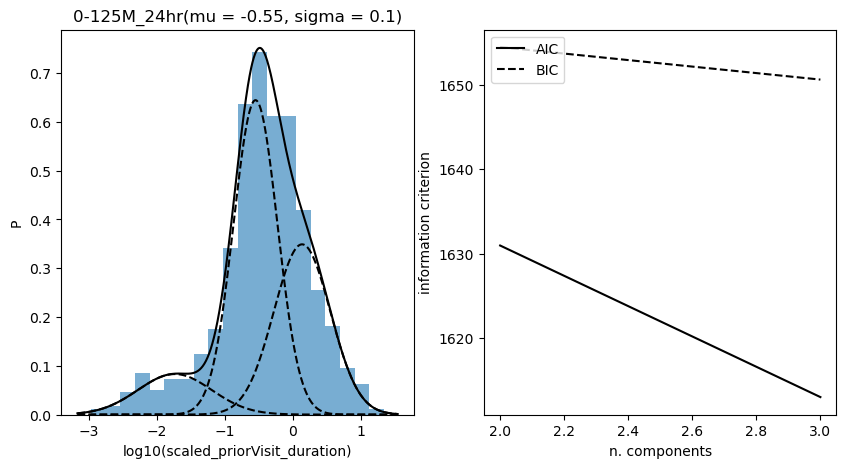

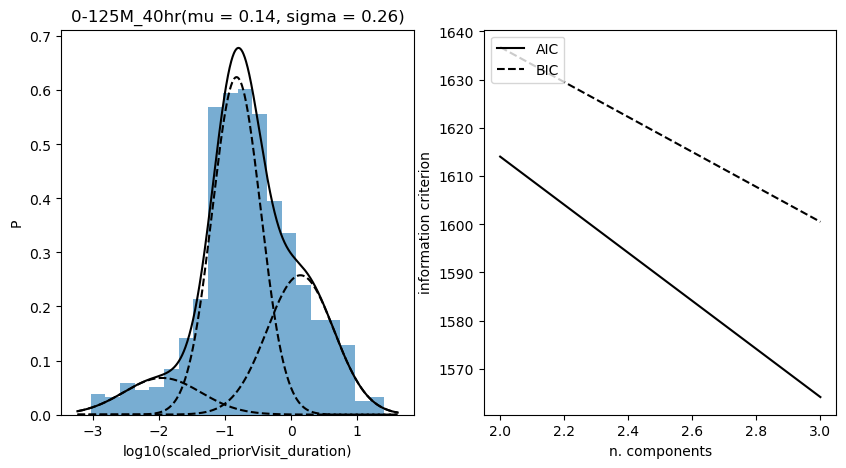

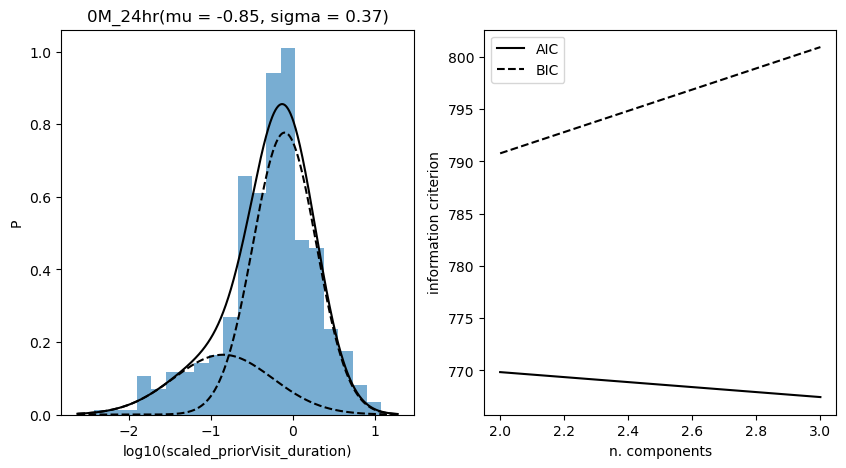

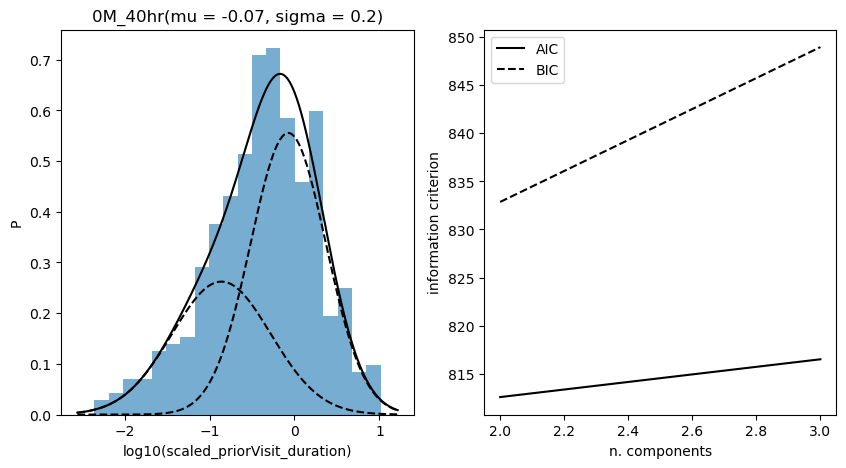

In [26]:
# check distribution of visit durations
condsOI = np.unique(per_trip_df_WT.condition.values) #['0-125M_24hr','0-125M_40hr']
qOI =  'scaled_priorVisit_duration' #'scaledbyloops_trip_distance', 'scaled_trip_duration', 'scaledbyloops_trip_duration'
ifabs = False
iflog = True
numbins = 50
Nmin = 2
Nmax = 3    
whichInfoCriteria = 'both' #'AIC' or 'BIC' or 'both'
for kk in range(len(condsOI)):
    filters = {'condition':condsOI[kk],
               # 'ifloop':[1]
              }
    relDF = GetRelevantDF(per_trip_df_WT,filters)
    datavec = relDF[qOI].values
    if ifabs == True:
        datavec = np.abs(datavec)
    if iflog == True:
        datavec = np.log10(np.abs(datavec[datavec!=0]))
        xname = 'log10(' + qOI + ')'
    else:
        xname = qOI
    fitGMM(datavec.reshape(-1,1),Nmin,Nmax, parameterPenaltyType = whichInfoCriteria, xlabel = xname, condOI = condsOI[kk], ifplot = True, 
            numbins = numbins,colwidth = 5, rowwidth = 5)

In [22]:
# Extract thresholds separating short,medium, long visits
condsOI = np.unique(per_trip_df_WT.condition.values) #['0-125M_24hr','0-125M_40hr']
qOI =  'scaled_priorVisit_duration' #'scaled_trip_distance'
numGaussians = 3

log10qthres_allconds = []
log10qthresMat = np.zeros((len(condsOI),numGaussians-1))
for condIndx in range(len(condsOI)):
    condOI = condsOI[condIndx]
    qVec = per_trip_df_WT[per_trip_df_WT.condition == condOI][qOI].values
    qVec = qVec[~np.isnan(qVec)]
    data_curr = np.log10(qVec[qVec>0])
    data_curr = data_curr.reshape(-1,1)
    
    xthres_all = extractGaussianIntersects_v2(data_curr,numGaussians)
    # xthres_all = extractGaussianIntersects(data_curr)
    # print(xthres_all)
    # log10qthres_allconds.append(xthres_all)
    log10qthresMat[condIndx,:] = np.hstack(xthres_all)

# print(log10qthres_allconds)
print(log10qthresMat)

[[-1.26181849 -0.13340962]
 [-1.62287402 -0.25327081]]


C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [24]:
np.unique(per_trip_df_WT.condition.values)

array(['0-125M_24hr', '0-125M_40hr', '0M_24hr', '0M_40hr'], dtype=object)

In [23]:
# augment per_trip_df with the type of prior visit (0,1,2 for short, medium, long respectively)
priorVisitType = []
for kk in range(len(condsOI)):
    condOI = condsOI[kk]
    qVals = np.log10(per_trip_df_WT[per_trip_df_WT.condition == condOI].scaled_priorVisit_duration.values)
    xthres_curr = log10qthresMat[kk,:]
    priorVisitType_curr = (qVals > xthres_curr[0]).astype(int) + (qVals > xthres_curr[1]).astype(int)
    priorVisitType.append(priorVisitType_curr)

per_trip_df_WT['priorVisitType'] = np.hstack(priorVisitType)

ValueError: Length of values (1511) does not match length of index (2424)

## How does the probability of taking a long trip vary as a function of prior visit type?

In [ ]:
per_trip_df_WT.columns

In [ ]:
condsOI = ['0-125M_24hr','0-125M_40hr']
PlongTrip = np.zeros((len(condsOI),3))
for condIndx in range(len(condsOI)):
    condOI = condsOI[condIndx]
    condDF = per_trip_df_WT[per_trip_df_WT.condition == condOI]
    for visitType in range(3):
        triptypeVals = condDF[condDF.priorVisitType == visitType].triptype.values
        PlongTrip[condIndx,visitType] = np.sum(triptypeVals)/len(triptypeVals)
        
print(PlongTrip)

# Create per-turn dataframe

In [21]:
# First, filter out other behavior from the dataframe (we're interested in runs and turns)
filters = {'ethogram':[0,1,2,3],
           'condition':condnames_genotypeOI}
perframeDF_filtered = GetRelevantDF(augmentedPerFrameDF_genotypeOI, filters)


In [22]:
ethogramOI = [1]
perTurnDF = CreatePerMoveSegmentDF_v2(perframeDF_filtered,metadata_genotypeOI,ethogramOI)
    

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

  0%|          | 0/108 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

  0%|          | 0/108 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

  0%|          | 0/108 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

In [23]:
# Augment per-turn dataframe with other properties
# radius of curvature of turn segments
perTurnDF['effArcRadius'] = perTurnDF['seg_length']/perTurnDF['absheadturnangle']

# trip properties
tripPropsOI = ['max_disp']
nanReplacements = [np.nan]
perTurnDF = AugmentSegDF_tripProps(perTurnDF, per_trip_df_genotypeOI, tripPropsOI, nanReplacements)



  0%|          | 0/108 [00:00<?, ?it/s]

In [24]:
perTurnDF.columns
# len(perTurnDF)

Index(['fly', 'condition', 'seg_state', 'etho_state', 'after_which_visit',
       'dist_since_visit', 'time_since_visit', 'cumRunTime_since_visit',
       'moveSegIndx', 'seg_duration', 'seg_length', 'disp_from_center',
       'seg_disp', 'velo', 'headturnangle', 'absheadturnangle',
       'numDirChanges', 'ifbigturn', 'ifCW', 'netReorientationAngle',
       'absReorientAngle', 'startmoveAngle_rel2food', 'ifpreferredturn',
       'numSegs', 'effArcRadius', 'max_disp'],
      dtype='object')

# Create per-move segment dataframe

Here we also augment the per-move dataframe with trip properties

In [25]:
ethogramOI = [1,2]
perMoveSegDF = CreatePerMoveSegmentDF_v2(perframeDF_filtered,metadata_genotypeOI,ethogramOI)
    

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

  0%|          | 0/108 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

  0%|          | 0/108 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

  0%|          | 0/108 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perMoveSegDf = perMoveSegDf.append(moveSegDf_fly, sort=False)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:276: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

In [26]:
# Augment per-segment dataframe with other properties
# radius of curvature of segments
perMoveSegDF['effArcRadius'] = perMoveSegDF['seg_length']/perMoveSegDF['absheadturnangle']

# trip properties
tripPropsOI = ['max_disp']
nanReplacements = [np.nan]

perMoveSegDF = AugmentSegDF_tripProps(perMoveSegDF, per_trip_df_genotypeOI, tripPropsOI, nanReplacements)

  0%|          | 0/108 [00:00<?, ?it/s]

In [25]:
perMoveSegDF.columns
# len(perMoveSegDF)

Index(['fly', 'condition', 'seg_state', 'etho_state', 'after_which_visit',
       'dist_since_visit', 'time_since_visit', 'cumRunTime_since_visit',
       'moveSegIndx', 'seg_duration', 'seg_length', 'disp_from_center',
       'seg_disp', 'velo', 'headturnangle', 'absheadturnangle',
       'numDirChanges', 'ifbigturn', 'ifCW', 'netReorientationAngle',
       'absReorientAngle', 'startmoveAngle_rel2food', 'ifpreferredturn',
       'numSegs', 'effArcRadius', 'max_disp'],
      dtype='object')

In [26]:
np.unique(perMoveSegDF.seg_state.values)

array([1, 2, 3, 4, 5])

# Create version of moveSegDF with only trips

Here, we also augment these move segment data frames with previous segment properties and changes in properties from previous segment.

In [27]:
filter_trip = {'seg_state':[2,3,4,5],'after_which_visit': np.arange(100)+1}
perMoveSegDF_tripsOnly = GetRelevantDF(perMoveSegDF,filter_trip)
perTurnDF_tripsOnly = GetRelevantDF(perTurnDF,filter_trip)

In [28]:
qOIs = ['seg_length', 'absheadturnangle', 'effArcRadius','ifpreferredturn']
perMoveSegDF_tripsOnly = AugmentSegDF_prevSegProp(perMoveSegDF_tripsOnly,qOIs)
perTurnDF_tripsOnly = AugmentSegDF_prevSegProp(perTurnDF_tripsOnly,qOIs)


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [29]:
perMoveSegDF_tripsOnly.columns
len(np.unique(perMoveSegDF_tripsOnly.fly.values))

101

In [30]:
qOIs = ['seg_length', 'absheadturnangle', 'effArcRadius']
perTurnDF_tripsOnly = AugmentSegDF_runturnchanges(perTurnDF_tripsOnly,qOIs)


  0%|          | 0/101 [00:00<?, ?it/s]

In [31]:
perTurnDF_tripsOnly['allsegdist_since_visit'] = perMoveSegDF_tripsOnly[perMoveSegDF_tripsOnly['etho_state']==1].dist_since_visit.values

In [32]:
perTurnDF_tripsOnly.columns

Index(['fly', 'condition', 'seg_state', 'etho_state', 'after_which_visit',
       'dist_since_visit', 'time_since_visit', 'cumRunTime_since_visit',
       'moveSegIndx', 'seg_duration', 'seg_length', 'disp_from_center',
       'seg_disp', 'velo', 'headturnangle', 'absheadturnangle',
       'numDirChanges', 'ifbigturn', 'ifCW', 'netReorientationAngle',
       'absReorientAngle', 'startmoveAngle_rel2food', 'ifpreferredturn',
       'numSegs', 'effArcRadius', 'max_disp', 'seg_length_prev',
       'absheadturnangle_prev', 'effArcRadius_prev', 'ifpreferredturn_prev',
       'dseg_length', 'dabsheadturnangle', 'deffArcRadius',
       'allsegdist_since_visit'],
      dtype='object')

# Augment trip properties with segment properties

In [34]:
per_trip_df_withTurnProps = AugmentTripDF_SegProps(per_trip_df_genotypeOI, perTurnDF_tripsOnly)

  0%|          | 0/101 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:801: RuntimeWarning: Mean of empty slice
  headturnangle_bias_rel = (np.nanmean(turnangles_preferred)-np.nanmean(turnangles_nonpreferred))/meanabsheadturnangle_trip
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:802: RuntimeWarning: Mean of empty slice
  log10effArcRadius_bias_rel = ((np.nanmean(log10effArcRadius_preferred)-np.nanmean(log10effArcRadius_nonpreferred))
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:802: RuntimeWarning: invalid value encountered in scalar divide
  log10effArcRadius_bias_rel = ((np.nanmean(log10effArcRadius_preferred)-np.nanmean(log10effArcRadius_nonpref

In [35]:
per_trip_df_withSegProps = AugmentTripDF_SegProps(per_trip_df_genotypeOI, perMoveSegDF_tripsOnly)

  0%|          | 0/101 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:801: RuntimeWarning: Mean of empty slice
  headturnangle_bias_rel = (np.nanmean(turnangles_preferred)-np.nanmean(turnangles_nonpreferred))/meanabsheadturnangle_trip
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:802: RuntimeWarning: Mean of empty slice
  log10effArcRadius_bias_rel = ((np.nanmean(log10effArcRadius_preferred)-np.nanmean(log10effArcRadius_nonpreferred))
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:802: RuntimeWarning: invalid value encountered in scalar divide
  log10effArcRadius_bias_rel = ((np.nanmean(log10effArcRadius_preferred)-np.nanmean(log10effArcRadius_nonpref

In [36]:
# Augment per-trip-DF with scaled variables
qOIs = ['distance_toFoodOrBorder']
per_trip_df_withSegProps = AugmentTripDF_scaledProps_v2(per_trip_df_withSegProps, qOIs)

  0%|          | 0/101 [00:00<?, ?it/s]

In [37]:
per_trip_df_withSegProps.columns
# np.sum(np.isnan(per_trip_df_withSegProps.distance_toFoodOrBorder.values))

Index(['fly', 'condition', 'which_trip', 'time', 'CF', 'CFF', 'trip_duration',
       'trip_distance', 'trip_CFFchange', 'trip_relCFFchange', 'max_disp',
       'max_disp_prevtrips', 'max_disp_sinceboundary',
       'numtrips_sinceboundary', 'priorVisit_duration', 'priorVisit_CFFstart',
       'priorVisit_CFFchange', 'priorVisit_relCFFchange',
       'priorVisit_CFchange', 'ifloop', 'dist2dispRatio', 'dist2durationRatio',
       'nextTrip_duration', 'nextVisit_duration', 'nextVisit_CFFchange',
       'nextVisit_relCFFchange', 'genotype', 'scaled_trip_distance',
       'scaledbyloops_trip_distance', 'scaled_trip_duration',
       'scaledbyloops_trip_duration', 'scaled_priorVisit_duration',
       'scaledbyloops_priorVisit_duration', 'numSegs', 'turnbias', 'CWfrac',
       'meanabsheadturnangle', 'meanlog10effArcRadius', 'headturnangle_bias',
       'log10effArcRadius_bias', 'numSegs_toFoodOrBorder',
       'distance_toFoodOrBorder', 'scaled_distance_toFoodOrBorder',
       'scaledbyloop

# Augment trip DF with trip type

In [39]:
np.unique(per_trip_df_withSegProps.condition.values)

array(['0-125M_24hr', '0-125M_40hr', '0M_24hr', '0M_40hr'], dtype=object)

C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

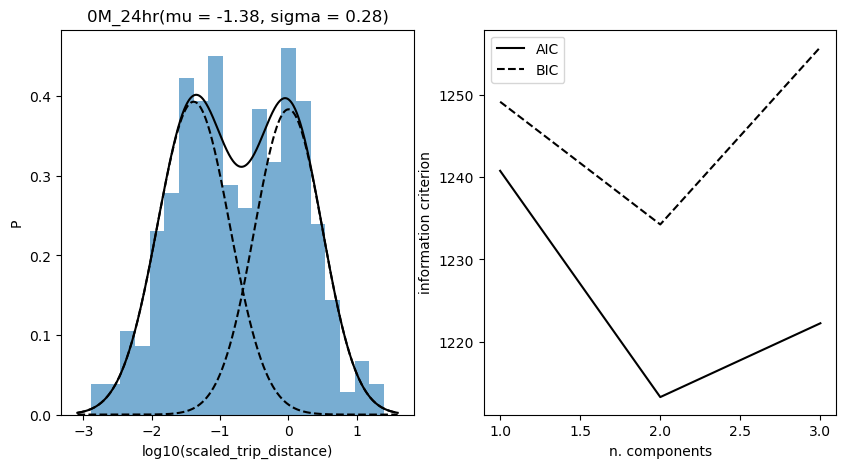

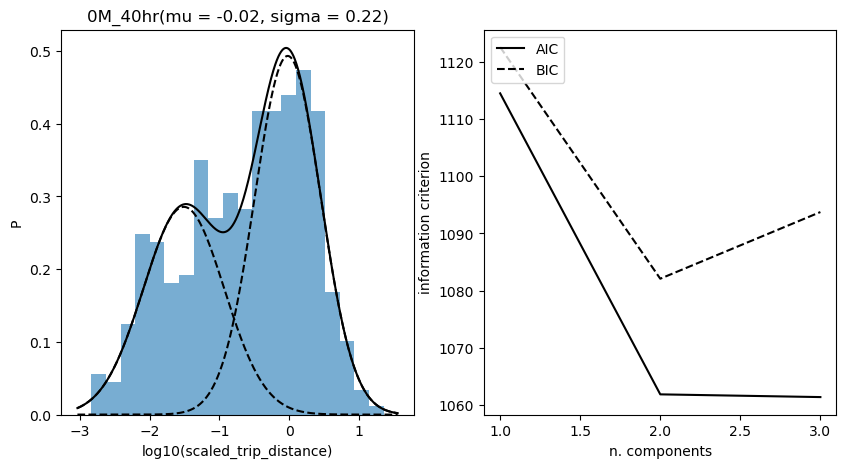

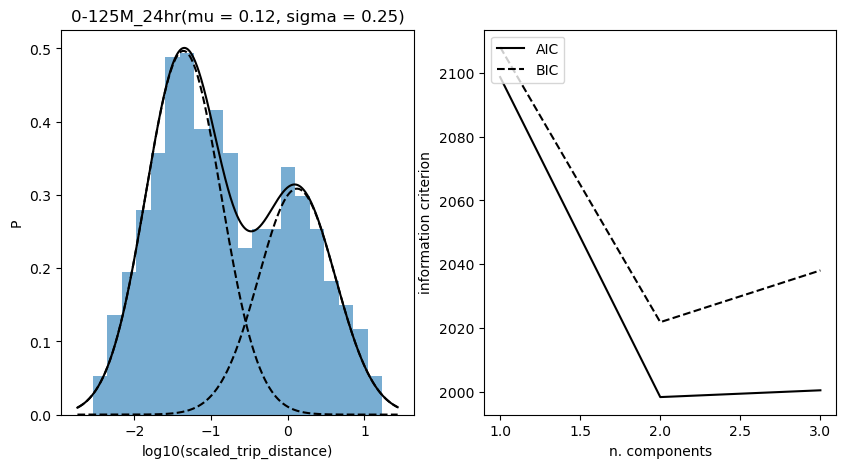

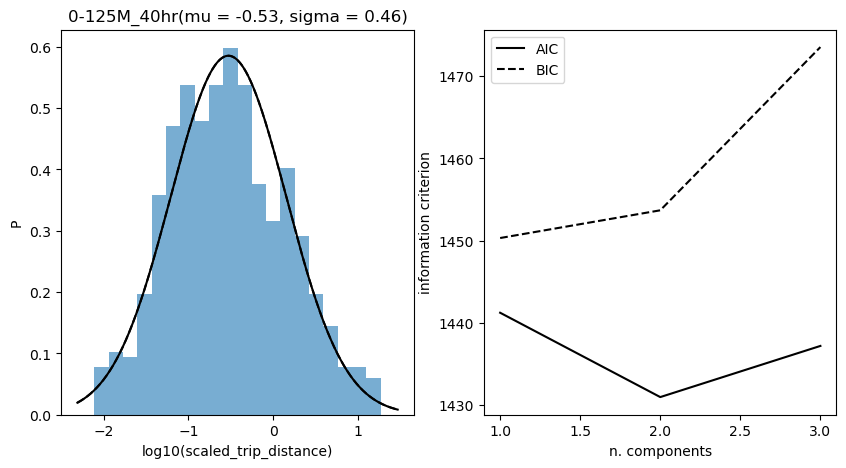

In [41]:
# Visualize distribution of scaled trip properties
condsOI = condnames_genotypeOI
qOI =  'scaled_trip_distance' #'scaledbyloops_trip_distance', 'scaled_trip_duration', 'scaledbyloops_trip_duration'
# qOI =  'scaled_distance_toFoodOrBorder' #'scaledbyloops_trip_distance', 'scaled_trip_duration', 'scaledbyloops_trip_duration'
ifabs = False
iflog = True
numbins = 50
Nmin = 1
Nmax = 3    
whichInfoCriteria = 'both' #'AIC' or 'BIC' or 'both'
for kk in range(len(condsOI)):
    filters = {'condition':condsOI[kk],
               # 'ifloop':[1]
              }
    # relDF = GetRelevantDF(per_trip_df_WT,filters)
    relDF = GetRelevantDF(per_trip_df_withSegProps,filters)
    datavec = relDF[qOI].values
    datavec = datavec[~np.isnan(datavec)]
    if ifabs == True:
        datavec = np.abs(datavec)
    if iflog == True:
        datavec = np.log10(np.abs(datavec[datavec!=0]))
        xname = 'log10(' + qOI + ')'
    else:
        xname = qOI
    fitGMM(datavec.reshape(-1,1),Nmin,Nmax, parameterPenaltyType = whichInfoCriteria, xlabel = xname, condOI = condsOI[kk], ifplot = True, 
            numbins = numbins,colwidth = 5, rowwidth = 5)

In [42]:
# Extract thresholds separating long and short trips, classify trips into short and long, and augment triptype to dataframe
condsOI = condnames_genotypeOI
qOI =  'scaled_trip_distance' #'scaled_trip_distance' #'scaledbyloops_trip_distance', 'scaled_trip_duration', 'scaledbyloops_trip_duration'
# qOI =  'scaled_distance_toFoodOrBorder' #'scaled_trip_distance' #'scaledbyloops_trip_distance', 'scaled_trip_duration', 'scaledbyloops_trip_duration'

log10qthresMat = np.zeros((len(condsOI),))
for condIndx in range(len(condsOI)):
    condOI = condsOI[condIndx]
    qVec = per_trip_df_withSegProps[per_trip_df_withSegProps.condition == condOI][qOI].values
    qVec = qVec[~np.isnan(qVec)]
    data_curr = np.log10(qVec[qVec>0])
    data_curr = data_curr.reshape(-1,1)
    
    xthres = extractGaussianIntersects(data_curr)
    log10qthresMat[condIndx] = xthres

print(log10qthresMat)

# classify trips into long and short for WT flies using quantity of interest
outdetection = None # 'dynamic_medcouple' #'medcouple' 
dfs2combine = []
for condIndxOI in range(len(condsOI)):
    condOI = condsOI[condIndxOI]
    longthres = 10**log10qthresMat[condIndxOI]
    df_curr = per_trip_df_withSegProps[per_trip_df_withSegProps.condition == condOI]
    df_curr = AugmentTripDF_triptype(df_curr,qOI,longthres, outlierdetection = outdetection)
    dfs2combine.append(df_curr)

per_trip_df_withSegProps = pd.concat(dfs2combine)    



C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Yipei\AppData\Local\Temp\ipykernel_29404\1785395478.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log10qthresMat[condIndx] = xthres
C:\Users\Yipei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Yipei\AppData\Local\Temp\ipykernel_29404\1785395478.py:15: DeprecationWarning: Conversion 

[-0.66928878 -0.79001362 -0.54844502 -0.42765614]


C:\Users\Yipei\AppData\Local\Temp\ipykernel_29404\1785395478.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log10qthresMat[condIndx] = xthres


  0%|          | 0/26 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:1063: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_trip_df['triptype'] = np.hstack(triptype)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:1064: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_trip_df['boutIndx'] = 

  0%|          | 0/22 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:1063: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_trip_df['triptype'] = np.hstack(triptype)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:1064: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_trip_df['boutIndx'] = 

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:1063: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_trip_df['triptype'] = np.hstack(triptype)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:1064: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_trip_df['boutIndx'] = 

  0%|          | 0/26 [00:00<?, ?it/s]

C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:1063: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_trip_df['triptype'] = np.hstack(triptype)
C:\Users\Yipei\OneDrive - Howard Hughes Medical Institute\Documents\foragingProject\Re__Hannah,_Dennis,_Yipei,_&_Ann_Meet\ToUpload\CreateNewDataFrames_singlespot_v2.py:1064: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_trip_df['boutIndx'] = 

# Augment per segment dataframe with trip type

In [43]:
per_trip_df_withSegProps.columns

Index(['fly', 'condition', 'which_trip', 'time', 'CF', 'CFF', 'trip_duration',
       'trip_distance', 'trip_CFFchange', 'trip_relCFFchange', 'max_disp',
       'max_disp_prevtrips', 'max_disp_sinceboundary',
       'numtrips_sinceboundary', 'priorVisit_duration', 'priorVisit_CFFstart',
       'priorVisit_CFFchange', 'priorVisit_relCFFchange',
       'priorVisit_CFchange', 'ifloop', 'dist2dispRatio', 'dist2durationRatio',
       'nextTrip_duration', 'nextVisit_duration', 'nextVisit_CFFchange',
       'nextVisit_relCFFchange', 'genotype', 'scaled_trip_distance',
       'scaledbyloops_trip_distance', 'scaled_trip_duration',
       'scaledbyloops_trip_duration', 'scaled_priorVisit_duration',
       'scaledbyloops_priorVisit_duration', 'numSegs', 'turnbias', 'CWfrac',
       'meanabsheadturnangle', 'meanlog10effArcRadius', 'headturnangle_bias',
       'log10effArcRadius_bias', 'numSegs_toFoodOrBorder',
       'distance_toFoodOrBorder', 'scaled_distance_toFoodOrBorder',
       'scaledbyloop

In [44]:
# trip properties
tripPropsOI = ['triptype']
nanReplacements = [np.nan]

perMoveSegDF_tripsOnly = AugmentSegDF_tripProps(perMoveSegDF_tripsOnly, per_trip_df_withSegProps, tripPropsOI, nanReplacements)
perTurnDF_tripsOnly = AugmentSegDF_tripProps(perTurnDF_tripsOnly, per_trip_df_withSegProps, tripPropsOI, nanReplacements)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

# Plot/fit distribution of segment lengths and changes in body/orientation angles 

In [45]:
perTurnDF_tripsOnly.columns
perMoveSegDF_tripsOnly.columns

Index(['fly', 'condition', 'seg_state', 'etho_state', 'after_which_visit',
       'dist_since_visit', 'time_since_visit', 'cumRunTime_since_visit',
       'moveSegIndx', 'seg_duration', 'seg_length', 'disp_from_center',
       'seg_disp', 'velo', 'headturnangle', 'absheadturnangle',
       'numDirChanges', 'ifbigturn', 'ifCW', 'netReorientationAngle',
       'absReorientAngle', 'startmoveAngle_rel2food', 'ifpreferredturn',
       'numSegs', 'effArcRadius', 'max_disp', 'seg_length_prev',
       'absheadturnangle_prev', 'effArcRadius_prev', 'ifpreferredturn_prev',
       'triptype'],
      dtype='object')

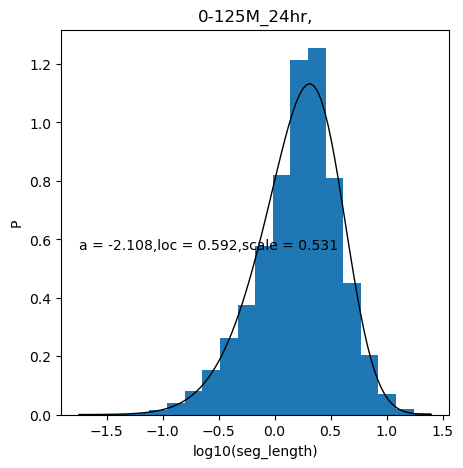

In [48]:
# extract data of interest
condOI = [condnames_genotypeOI[2]]
triptypeOI = [0,1]
filters = {'seg_state':[2,4],
           'etho_state':[1], # 1: turns, 2: runs,
           # 'numDirChanges':[0,1],
           # 'moveSegIndx':[0,1],
           # 'triptype':triptypeOI,
           # 'priorVisitType':[2],
           'condition':condOI}
perTurnDF_OI = GetRelevantDF(perMoveSegDF_tripsOnly,filters)
# perTurnDF_OI = perTurnDF_OI[perTurnDF_OI.absheadturnangle >0.05*np.pi]
# perTurnDF_OI = perTurnDF_OI[perTurnDF_OI.numSegs <= 5]
qOI = 'seg_length'  #'effArcRadius' #'absheadturnangle' #'seg_length' 
if qOI == 'seg_length':
    iflogq = True
    if iflogq == True:
        distOI = 'skewnorm' #'genlogistic' #'skewnorm'
        possibleDists = ['genlogistic','genhyperbolic','skewnorm']
    else:
        possibleDists = ['logistic','lognorm','moyal','gamma','gumbel_r']
elif qOI == 'absheadturnangle':
    iflogq = False
    if iflogq == False:
        distOI = 'lognorm'       
        possibleDists = ['gumbel_r','lognorm','rayleigh','gamma']
    else:
        distOI = 'skewnorm' #'skewcauchy' 
        possibleDists = ['genhyperbolic','johnsonsu','genlogistic','burr12','loggamma','norm','skewnorm','skewcauchy']
elif qOI == 'effArcRadius':
    iflogq = True
    if iflogq == True:
        distOI = 'genlogistic' #'genlogistic' #'skewnorm'
        possibleDists = ['genlogistic','genhyperbolic','skewnorm']
    else:
        distOI = 'lognorm'

ifExploreDists = False
if ifExploreDists == True:
    qoIvec = perTurnDF_OI[qOI].values
    qoIvec = qoIvec[~np.isnan(qoIvec)]
    qoIvec = qoIvec[qoIvec!=0]
    if iflogq == False:
        datavec = qoIvec
    else:
        datavec = np.log10(np.abs(qoIvec[qoIvec!=0]))       
    
    # Define fitter
    if len(possibleDists) == 0:
        f = Fitter(datavec)
    else:
        f = Fitter(datavec, distributions=possibleDists)
    
    f.fit()
    f.summary()
else:
    criteria = {}
    numbins = 20
    fittedparams = plot_distribution_v2(perTurnDF_OI, qOI, {"0":condOI}, criteria, numbins = numbins, colwidth = 5, rowwidth = 5,
          iflog = iflogq, ifpdf = True, fitdist = distOI, fn2save = None)
            

# Fit initial distributions

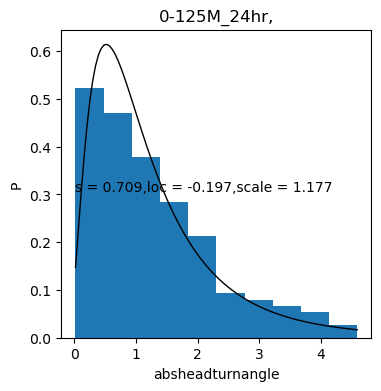

In [49]:
# extract data of interest
# conds2include = condnames_genotypeOI
conds2include = [condnames_genotypeOI[2]]
ethostateOI = [1] # 1 for turns, 2 for runs
triptypeOI = [0] # 0: short trips, 1: long trips
# turnDirOI = [1]
filters = {'seg_state':[2,4],
           # 'moveSegIndx':[0,1],
           # 'moveSegIndx':[0,1,2,3],
           'etho_state':ethostateOI,
           'triptype':triptypeOI,
           # 'ifpreferredturn':turnDirOI,
           'condition':conds2include}
relDF = GetRelevantDF(perMoveSegDF_tripsOnly,filters)
relDF = relDF[relDF.numSegs.values <= 5]
# relDF = relDF[relDF.dist_since_visit <= 0.001]
# relDF = relDF[relDF.Preturn >= 0.8]
qOI = 'absheadturnangle' #'effArcRadius' #'absheadturnangle' #'seg_length' 
if qOI == 'absheadturnangle':
    iflogq = False
    distOI = 'lognorm'
elif qOI == 'effArcRadius':
    iflogq = True
    distOI = 'genlogistic' #'skewnorm' #'genlogistic'
else:
    iflogq = True
    distOI = 'skewnorm' #'genlogistic' #'skewnorm'

conds2include_dict = {"0":conds2include}
criteria = {}
numbins = 10
fittedparams = plot_distribution_v2(relDF, qOI, conds2include_dict, criteria, numbins = numbins, colwidth = 4, rowwidth = 4,
      iflog = iflogq, ifpdf = True, fitdist = distOI, fn2save = None)
            

0.3722122957582323


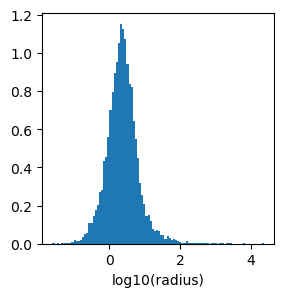

In [47]:
conds2include = condnames_genotypeOI
filters = {'seg_state':[2,4],
           'etho_state':[1], # 1 for turns, 2 for runs
           # 'numSegs':[1,2,3,4,5],
           # 'moveSegIndx':[0,1],
           'condition':conds2include,
           'numDirChanges':[0]
          }
perTurnDF_OI = GetRelevantDF(perMoveSegDF,filters)
# perTurnDF_OI = GetRelevantDF(perTurnDF,filters)
# perTurnDF_OI = perTurnDF_OI[perTurnDF_OI.max_disp.values <4] 
datavec = perTurnDF_OI['seg_length'].values/perTurnDF_OI['absheadturnangle'].values
ifabs = False
iflog = True
if ifabs == True:
    datavec = np.abs(datavec)
if iflog == True:
    datavec = np.log10(np.abs(datavec[datavec!=0]))
    xname = 'log10(radius)'
else:
    xname = 'radius'
print(np.mean(datavec))
numbins = 100
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
vals = ax.hist(datavec, numbins, density = True)   
ax.set_xlabel(xname);


# How parameters of a distribution change over a trip or as a function of another variable

In [54]:
perMoveSegDF_tripsOnly.columns

Index(['fly', 'condition', 'seg_state', 'etho_state', 'after_which_visit',
       'dist_since_visit', 'time_since_visit', 'cumRunTime_since_visit',
       'moveSegIndx', 'seg_duration', 'seg_length', 'disp_from_center',
       'seg_disp', 'velo', 'headturnangle', 'absheadturnangle',
       'numDirChanges', 'ifbigturn', 'ifCW', 'netReorientationAngle',
       'absReorientAngle', 'startmoveAngle_rel2food', 'ifpreferredturn',
       'numSegs', 'effArcRadius', 'max_disp', 'seg_length_prev',
       'absheadturnangle_prev', 'effArcRadius_prev', 'ifpreferredturn_prev',
       'triptype'],
      dtype='object')

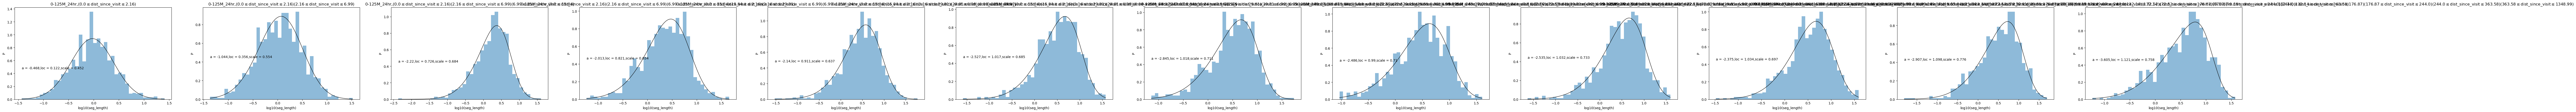

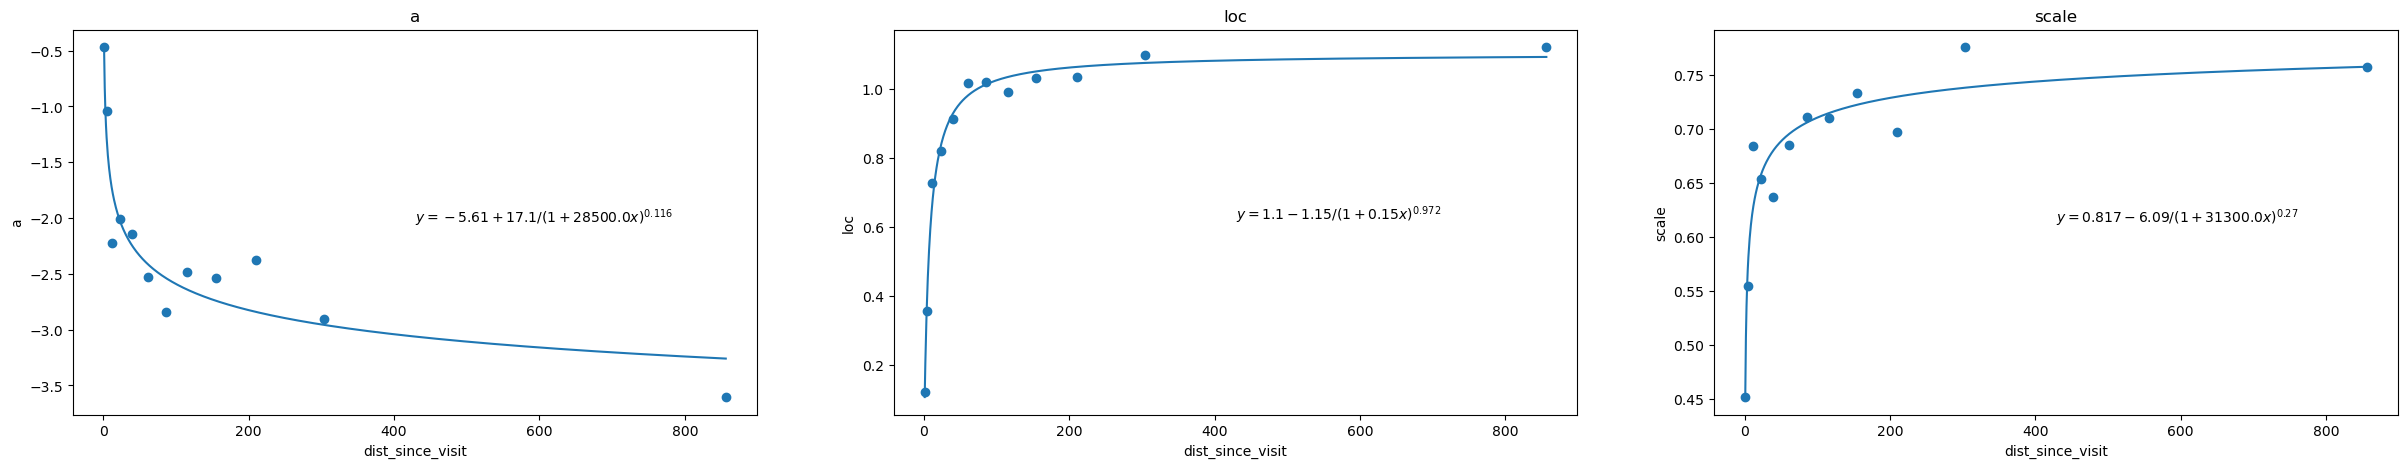

In [53]:
df2use = perMoveSegDF_tripsOnly #perTurnDF_tripsOnly # perMoveSegDF_tripsOnly
# conds2include = condnames_genotypeOI
conds2include = [condnames_genotypeOI[2]]
ethostateOI = [2] # 1 for turns, 2 for runs
turnDirOI = [0,0.5,1] # 1: preferred turn direction, 0: opposite of preferred turn direction, 0.5: neither
triptypes2include = [0,1]
fnpart_conds = '_'.join(conds2include)
if len(ethostateOI) == 1:
    fnpart_etho = 'etho' + str(ethostateOI[0])
else:
    fnpart_etho = 'ethoBoth'
if len(turnDirOI) == 1:
    fnpart_turndir = 'ifprefdir' + str(turnDirOI[0])
else:
    fnpart_turndir = ''
if len(triptypes2include) == 1:
    fnpart_triptype = 'triptype' + str(triptypes2include[0])
else:
    fnpart_triptype = 'alltrips'

filters = {'seg_state':[2,4], #[2,4],
           'etho_state': ethostateOI,
           'triptype': triptypes2include,
           'condition':conds2include}
# filters = {'seg_state':[2,4],
#            'which_run':[0],
#            'condition':conds2include}
relDF = GetRelevantDF(df2use,filters)
qOI = 'seg_length'  #'effArcRadius' #   #'seg_length' #'absheadturnangle' 
xVar = 'dist_since_visit' #'moveSegIndx' #'absheadturnangle' #'after_which_visit' #'which_run' #'dist_since_visit'
ifautoxbin = True
if ifautoxbin == True:
    numbins = 12
    xBinEdges, xBinMid = autobin(relDF[xVar].values,numbins=numbins)
    # print(xBinEdges)
    criteria = {i:{xVar: {'min': xBinEdges[i], 'max': xBinEdges[i+1]}} for i in range(numbins)}
else:
    criteria = {
        0: {xVar: {'min': -0.5, 'max': 3}},
        1: {xVar: {'min': 2.5, 'max': 5}},
        2: {xVar: {'min': 4.5, 'max': 7.5}},
        3: {xVar: {'min': 6.5, 'max': 9.5}},
        4: {xVar: {'min': 8.5, 'max': 10.5}},
        5: {xVar: {'min': 9.5, 'max': 12.5}},
        6: {xVar: {'min': 11.5, 'max': 200}},
        # 7: {xVar: {'min': 100, 'max': np.max(perRunDF_OI[xVar].values)}},
        }

if qOI == 'absheadturnangle':
    iflog = False
    if iflog == False:
        dist2fit = 'lognorm' #'truncnorm' #'lognorm' # 'norm' #'skewnorm'
    else:
        dist2fit = 'genhyperbolic'
elif qOI == 'seg_length':
    iflog = True
    dist2fit = 'skewnorm' #'genlogistic' #'skewnorm'
elif qOI == 'effArcRadius':
    iflog = True
    dist2fit = 'genlogistic' #'genlogistic' #'skewnorm'
    
fitparamsFuncType = 'PLfunc' # None #'ExpFunc' #'sumTwoExpFunc' #'ExpFunc' #'PLfunc'
if (dist2fit != None ) and (fitparamsFuncType != None):
    if iflog == False:
        fnpart_fit = 'Fit_' + qOI + 'VS' + xVar
        fn2save = foldername_save + dist2fit + fnpart_fit + '_' + fitparamsFuncType + '_' + fnpart_etho + '_' + fnpart_turndir + '_' + fnpart_triptype + '_' + fnpart_conds + '.pdf'
    elif iflog == True:
        fnpart_fit = 'Fit_log10' + qOI + 'VS' + xVar
        fn2save = foldername_save + dist2fit + fnpart_fit + '_' + fitparamsFuncType + '_' + fnpart_etho + '_' + fnpart_turndir + '_' + fnpart_triptype + '_' + fnpart_conds + '.pdf'
fn2save = None
numbins = 40
iflogkey = False
(fittedparamsMat, xVarVec) = plot_distribution_varycriteria_v2(relDF,qOI,conds2include, criteria, numbins = numbins, alpha = 0.5,
                      iflog = iflog, ifpdf = True, fitdist = dist2fit, fitparamsFuncType = fitparamsFuncType, colwidth = 10, rowwidth = 5, 
                      ifoverlap = False, iflogkey = iflogkey, otherparams = None, maxnumeval = 8000, fn2save = fn2save)


# How turn bias varies over a trip

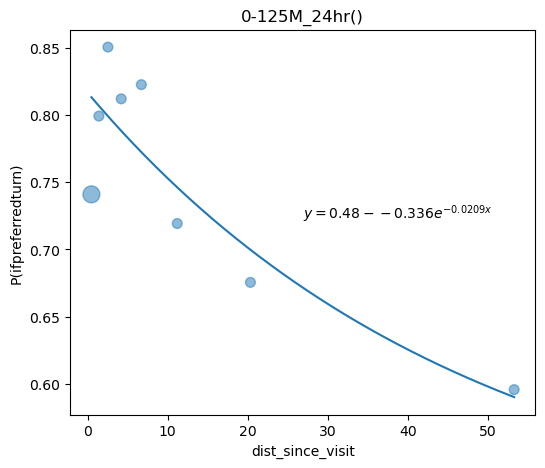

In [61]:
# conds2include = condnames_genotypeOI
conds2include = [condnames_genotypeOI[2]]
# conds2include = ['0M_24hr','0M_40hr','0-125M_24hr','0-125M_40hr']
ethostateOI = [1] # 1 for turns, 2 for runs
triptypeOI = [0]
filters = {'seg_state':[2,4],
           'etho_state':ethostateOI,
           'triptype':triptypeOI,
           'condition':conds2include}
relDF = GetRelevantDF(perTurnDF_tripsOnly,filters)
# relDF = relDF[relDF.numSegs.values<=5]
# relDF = relDF[relDF.max_disp.values<10]
# relDF = relDF[relDF.Preturn.values>=0.7]
yVar = 'ifpreferredturn'
xVar = 'dist_since_visit'
# xVar = 'moveSegIndx'
# xVar = 'allsegdist_since_visit' #'moveSegIndx' #'allsegdist_since_visit'
criteria = {
    0: {}, 
}
# criteria = {
#     0: {}, 1: {'triptype':{'min':0, 'max':0}}, 2: {'triptype':{'min':1, 'max':1}}, 
# }
# fig_fn = foldername_save + 'P' + yVar + 'VS' + xVar + '.pdf'
fig_fn = None

auto_xBin = True
autoNumxbins = 10
fitType = 'ExpFunc' #'sumTwoExpFunc_v2' #'sumTwoExpFunc' #'ExpFunc' #'PLfunc'
plotPevent_varyx_specifycriteria(relDF, yVar, xVar, [], criteria, ifshowNsamples = False, minmksize = 0.2, sizefactor = 0.2,
                      rounding = 2, colwidth = 6, rowwidth = 5, ifoverlap = True, xlabeltype = 'binrange', auto_xBin = auto_xBin, 
                      autoNumxbins = autoNumxbins, fitparamsFuncType = fitType, fn2save = fig_fn)


In [73]:
perMoveSegDF_tripsOnly.columns

Index(['fly', 'condition', 'seg_state', 'etho_state', 'after_which_visit',
       'dist_since_visit', 'time_since_visit', 'cumRunTime_since_visit',
       'moveSegIndx', 'seg_duration', 'seg_length', 'disp_from_center',
       'seg_disp', 'velo', 'headturnangle', 'absheadturnangle',
       'numDirChanges', 'ifbigturn', 'ifCW', 'netReorientationAngle',
       'absReorientAngle', 'startmoveAngle_rel2food', 'ifpreferredturn',
       'numSegs', 'effArcRadius', 'max_disp', 'seg_length_prev',
       'absheadturnangle_prev', 'effArcRadius_prev', 'ifpreferredturn_prev',
       'triptype'],
      dtype='object')

In [1361]:
len(datavec)

11798

In [79]:
conds2include = ['0-125M_24hr']
ethostateOI = [2] # 1:turn, 2: run
filters = {'seg_state':[2,4],
          'etho_state':ethostateOI,
          # 'triptype': [0],
          'condition':conds2include}
relDF = GetRelevantDF(perMoveSegDF_tripsOnly,filters)
relDF = relDF[relDF.numSegs.values <=5]
qOI = 'seg_length'  #'effArcRadius' #'absheadturnangle' #'seg_length' 
iflogq = True
datavec = relDF[qOI].values
if iflogq == True:
    datavec = np.log10(np.abs(datavec[datavec!=0]))
    qName = 'log10(' + qOI + ')'
else:
    qName = qOI
fn2save = qName + '_veryShortTrips_' + conds2include[0] + '.csv'
# fn2save = qName + '_allTrips_' + conds2include[0] + '.csv'
# fn2save = qName + '_shortTrips_' + conds2include[0] + '.csv'
np.savetxt(fn2save, datavec, delimiter=",")

In [198]:
xVar = 'max_disp'
xthresVec = [0, 2, 4, 6, 8, 10, 15, 20, 30, 40, 50, 60]
PreturnDF_givenDisp = CreatePreturnDF(per_trip_df_withSegProps, xVar, xthresVec)



In [200]:
conds2include = condnames_genotypeOI
PreturnDF_givenDisp_OI = PreturnDF_givenDisp[PreturnDF_givenDisp.condition == condOI]
numxgrps = len(xthresVec)
numflies = len(np.unique(PreturnDF_givenDisp_OI.fly.values))
PreturnMat_givenDisp = np.zeros((numxgrps,numflies))
meanPreturnVec_givenDisp = np.zeros((numxgrps,))
medianPreturnVec_givenDisp = np.zeros((numxgrps,))
for xGroup in range(numxgrps):
    PreturnVec = PreturnDF_givenDisp_OI[PreturnDF_givenDisp_OI.xGroup.values == str(xGroup)].Preturn.values
    numvals = len(PreturnVec)
    if numvals > 0:
        PreturnMat_givenDisp[xGroup,0:numvals] = PreturnVec
        meanPreturnVec_givenDisp[xGroup] = np.nanmean(PreturnVec)
        medianPreturnVec_givenDisp[xGroup] = np.nanmedian(PreturnVec)
    else:
        meanPreturnVec_givenDisp[xGroup] = np.nan
        medianPreturnVec_givenDisp[xGroup] = np.nan


In [202]:
# PreturnMat_givenDisp

In [203]:
fn2save = 'PreturnMat_givenDisp' + conds2include[0] + '.csv'
np.savetxt(fn2save, PreturnMat_givenDisp, delimiter=",")

fn2save = 'meanPreturnVec_givenDisp' + conds2include[0] + '.csv'
np.savetxt(fn2save, meanPreturnVec_givenDisp, delimiter=",")

fn2save = 'medianPreturnVec_givenDisp' + conds2include[0] + '.csv'
np.savetxt(fn2save, medianPreturnVec_givenDisp, delimiter=",")

fn2save = 'maxDispThres_' + conds2include[0] + '.csv'
np.savetxt(fn2save, xthresVec, delimiter=",")

In [1428]:
xVar = 'numSegs_toFoodOrBorder'
xthresVec = [0, 1, 2, 4, 6, 8, 10, 15, 20, 60, 100, 200, 600, 1000]
PreturnDF_givenNumSegs = CreatePreturnDF(per_trip_df_WT, xVar, xthresVec)

condOI = '0-125M_24hr'
PreturnDF_givenNumSegs_OI = PreturnDF_givenNumSegs[PreturnDF_givenNumSegs.condition == condOI]
numxgrps = len(xthresVec)
numflies = len(np.unique(PreturnDF_givenNumSegs_OI.fly.values))
PreturnMat_givenNumSegs = np.zeros((numxgrps,numflies))
meanPreturnVec_givenNumSegs = np.zeros((numxgrps,))
medianPreturnVec_givenNumSegs = np.zeros((numxgrps,))
for xGroup in range(numxgrps):
    PreturnVec = PreturnDF_givenNumSegs_OI[PreturnDF_givenNumSegs_OI.xGroup.values == str(xGroup)].Preturn.values
    numvals = len(PreturnVec)
    if numvals > 0:
        PreturnMat_givenNumSegs[xGroup,0:numvals] = PreturnVec
        meanPreturnVec_givenNumSegs[xGroup] = np.nanmean(PreturnVec)
        medianPreturnVec_givenNumSegs[xGroup] = np.nanmedian(PreturnVec)
    else:
        meanPreturnVec_givenNumSegs[xGroup] = np.nan
        medianPreturnVec_givenNumSegs[xGroup] = np.nan

fn2save = 'PreturnMat_givenNumSegs' + '.csv'
np.savetxt(fn2save, PreturnMat_givenNumSegs, delimiter=",")

fn2save = 'meanPreturnVec_givenNumSegs' + '.csv'
np.savetxt(fn2save, meanPreturnVec_givenNumSegs, delimiter=",")

fn2save = 'medianPreturnVec_givenNumSegs' + '.csv'
np.savetxt(fn2save, medianPreturnVec_givenNumSegs, delimiter=",")

fn2save = 'NumSegsThres' + '.csv'
np.savetxt(fn2save, xthresVec, delimiter=",")

In [1430]:
medianPreturnVec_givenNumSegs

array([0.8372093 , 0.81578947, 0.78787879, 0.69230769, 0.65      ,
       0.58823529, 0.58333333, 0.52272727, 0.5       , 0.33333333,
       0.        , 0.        ,        nan,        nan])